# **DONT RUN!!!** Function which fetches data for label encoding


In [ ]:
!pip install geopy

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="latLongToTownNameCis419")  # Replace 'geoapiExercises' with a relevant user-agent name for your app

def reverse_geocode(lat_lon_str):
    # Perform reverse geocoding
    location = geolocator.reverse(lat_lon_str, exactly_one=True)
    if location:
        address = location.raw['address']
        city = address.get('city', '') or address.get('town', '') or address.get('village', '') or address.get('hamlet', '') or address.get('county', '')
        county = address.get('county') or "United Kingdom"
        state = address.get('state') or "United Kingdom"
        country = address.get('country', '')
        return city, county, state, country
    else:
        return "No address found for this location."

# Example coordinates
latitude = "57.618735"
longitude = "-5.301776"
address = reverse_geocode(latitude + "," + longitude)
print(address)

('Kinlochewe', 'Highland', 'Alba / Scotland', 'United Kingdom')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import csv

# Path to the main directory
path = '/content/drive/My Drive/ukCities/'

# Get a list of all items in the main directory
items = os.listdir(path)

# Loop through each item
for item in items:
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"Contents of '{item}':")
        # Open a CSV file to write the coordinates and corresponding city, country
        if os.path.exists(f'{item_path}/{item}.csv'):
          print(f"CSV alr found for file {item}")
          continue
        with open(f'{item_path}/{item}.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Coords", "City","County","State", "Country"])  # Writing header

            coords = os.listdir(item_path)
            for coord in coords:
                if "csv" in coord:
                  break
                city, county, state, country = reverse_geocode(coord)
                print(f" - {coord}")
                print(city, county, state, country)
                writer.writerow([coord, city, county, state, country])
                time.sleep(1.25)  # Delay to simulate reverse geocoding time
        print(f"--> commited file for section {item}")
        print()  # Add a newline for better readability between directories


Mounted at /content/drive
Contents of '0':
 - 51.51246707557728,-0.122817504141949
London United Kingdom England United Kingdom
 - 51.51045715839658,-0.1312926775503911
London United Kingdom England United Kingdom
 - 51.50894851442547,-0.1269157994979564
City of Westminster United Kingdom England United Kingdom
 - 51.51060984011609,-0.1295334714796184
London United Kingdom England United Kingdom
 - 51.51102821926477,-0.1294777059276555
London United Kingdom England United Kingdom
 - 51.50986431221067,-0.1308874428409865
City of Westminster United Kingdom England United Kingdom
 - 51.50871051188366,-0.1268771839892324
London United Kingdom England United Kingdom
 - 51.50999073233947,-0.1288325243743031
London United Kingdom England United Kingdom
 - 51.50958376860204,-0.1299395468931834
City of Westminster United Kingdom England United Kingdom
 - 51.51030728182054,-0.1294699647386039
London United Kingdom England United Kingdom
 - 51.51090024573446,-0.1298218455266635
London United King

KeyboardInterrupt: 

# **Start Here:** Create the Dataloader for the model

In [ ]:
from transformers import CLIPProcessor, CLIPModel

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
import pandas as pd
import torch
import os
from google.colab import drive
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import Compose

# Import the DistilBERT tokenizer
from transformers import DistilBertTokenizer
import time

drive.mount('/content/drive')
ImageFile.LOAD_TRUNCATED_IMAGES = True

class ParallelUKClip(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.grids = []
        self.data = self.load_data()

    def load_csv_data(self, index):
        """ Helper function to process each CSV file in a separate thread """
        csv_path = os.path.join(self.root_dir, str(index), f"{index}.csv")
        df = pd.read_csv(csv_path)
        data = []
        print("Grid #: ", index)
        self.grids.append(f"Grid {index}")
        for _, row in df.iterrows():
            folder_path = os.path.join(self.root_dir, str(index), row['Coords'])
            img_files = os.listdir(folder_path)
            img_paths = [os.path.join(folder_path, img_file) for img_file in img_files]

            label = f"Grid {index}"
            tokenized_label = self.tokenizer(label, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
            coords = row['Coords']
            data.extend([(img_path, tokenized_label, label, coords) for img_path in img_paths])
        return data

    def load_data(self):
        num_grids = len(os.listdir(self.root_dir))
        with ThreadPoolExecutor() as executor:
            results = executor.map(self.load_csv_data, range(num_grids - 1))
        data = []
        for result in results:
            data.extend(result)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label, grid, coords = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Tokenize the label
        item = {}
        item['image'] = image
        item['label'] = label
        item['grid'] = grid
        item['coords'] = coords
        item['path'] = img_path
        return item

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cityPicCount = {}

class ParallelUKCitiesClip(Dataset): # Dataset for UK Cities only!
    def __init__(self, root_dir, transform=None):
        self.topdf = pd.read_csv("/content/drive/My Drive/uk_cities_top_150.csv") # changed from UK_top_50_cities.csv
        self.hasParents = True # change to True if top 150
        self.root_dir = root_dir
        self.transform = transform
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.paths = []
        self.cities = []
        self.data = self.load_data()

    def load_csv_data(self, index):
        row = self.topdf.iloc[index]
        city = ""
        if not self.hasParents:
            city = row['City']
        else:
          # Check if the row is empty or if 'ParentCity' is missing or not a string
          if not pd.isna(row['ParentCity']):
              print("Test")
              city = row['ParentCity']
          else:
              city = row['City']
        self.cities.append(city)
        totalPics = 0
        print("City: " + city +  " ", index)
        og_folder_path = os.path.join(self.root_dir, str(index))
        coord_folders = os.listdir(og_folder_path)
        coord_folder_paths = [os.path.join(og_folder_path, coord_folder) for coord_folder in coord_folders]

        data = []
        for folder_path in coord_folder_paths:
            img_files = os.listdir(folder_path)
            img_paths = [os.path.join(folder_path, img_file) for img_file in img_files]

            label = f"A picture of {city}"
            tokenized_label = self.tokenizer(label, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
            data.extend([(img_path, tokenized_label, city) for img_path in img_paths])
            totalPics += len(img_paths)

        if city in cityPicCount:
          cityPicCount[city] += totalPics
        else:
          cityPicCount[city] = totalPics
        return data

    def load_data(self):
        num_grids = len(os.listdir(self.root_dir))
        with ThreadPoolExecutor() as executor:
            results = executor.map(self.load_csv_data, range(num_grids - 1))
        data = []
        for result in results:
            data.extend(result)
        self.paths = [item[0] for item in data]
        self.cities = list(set(self.cities)) # remove duplicates
        return data

    def __len__(self):
        return len(self.data)

    def getPaths(self):
        return self.paths

    def __getitem__(self, idx):
        img_path, label, city = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Tokenize the label
        item = {}
        item['image'] = image
        item['label'] = label
        item['city'] = city
        item['path'] = img_path
        return item

# Encoders

In [ ]:
!pip install timm

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import timm

class ImageEncoder(nn.Module): # Encode images to a fixed size vector
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'resnet50', pretrained=True, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [ ]:
from transformers import DistilBertModel

class TextEncoder(nn.Module): # Encode text to a fixed size vector
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        for p in self.model.parameters():
            p.requires_grad = True

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1) # need to squeeze from [batch_size, 1, 512] to [batch_size, 512]

        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256, # required by CLIP paper
        dropout=0.1
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x


# Model Architecture

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch['label']["input_ids"], attention_mask=batch['label']["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )

        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

# Train Helpers

In [30]:
import numpy as np
import albumentations as A
from torch.utils.data import random_split

def get_transforms():
    return Compose([
          transforms.ToTensor(),
          transforms.Normalize([0, 0, 0], [1, 1, 1])
        ])

def build_loaders():
    transformer = get_transforms()
    dataset = ParallelUKCitiesClip(root_dir='/content/drive/My Drive/ukCitiesTop50/', transform=transformer) # changed from ukCitiesTop50

    # Define the split sizes
    train_split = 0.7
    val_split = 0.2
    test_split = 0.1

    train_size = int(len(dataset) * train_split)
    val_size = int(len(dataset) * val_split)
    test_size = len(dataset) - train_size - val_size

    # Randomly split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders for Train/Val/Test
    train_loader = DataLoader(train_dataset, batch_size=32, num_workers=10, pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, num_workers=10, pin_memory=True, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=10, pin_memory=True, shuffle=False)

    return train_loader, val_loader, test_loader, dataset

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# Train the model!

In [31]:
train_loader, valid_loader, test_loader, dataset = build_loaders() # Create DataLoaders. Also get Dataset (needed later)
print(len(grids))

City: London  0
City: Birmingham  1
City: Portsmouth  2
City: Southampton  3
City: Nottingham  4
City: Bristol  5
City: Manchester  6
City: Liverpool  7
City: Leicester  8
City: Worthing  9City: Coventry  10

City: Belfast  11
City: Bradford  12
City: Derby  13
City: Plymouth  14
Test
City: London  15
City: Wolverhampton  16
City: Northampton City: Norwich  18City: Luton  19

 17
Test
City: Birmingham  20
Test
City: London  21
City: Aberdeen  22
City: Croydon  23
City: Bournemouth  24
City: Basildon  25
City: Maidstone  26
Test
City: London  27
City: Warrington  28
City: Oxford  29
Test
City: London  30
City: West Bromwich  31
City: Gloucester  32
City: York  33
City: Blackpool  34
City: Stockport  35
Test
City: Manchester  36
Test
City: London  37
City: Cambridge  38
Test
City: London  39
City: Colchester  40
City: High Wycombe  41
City: Gateshead  42
City: Slough  43
City: Blackburn  44
City: Chelmsford  45
City: Rochdale  46
City: Rotherham  47
Test
City: London  48


AttributeError: 'ParallelUKCitiesClip' object has no attribute 'grids'

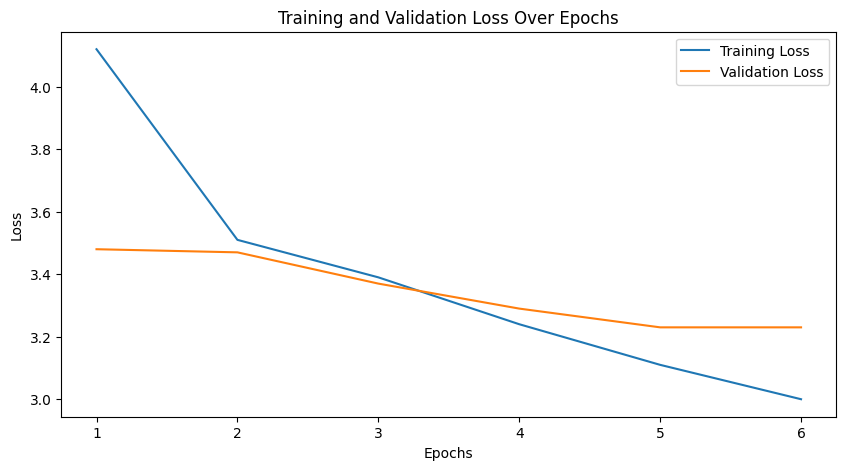

In [ ]:
import itertools
from tqdm.autonotebook import tqdm
from google.colab import files
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    model = CLIPModel().to(device)

    # Some hyperparameters are specified in CLIP paper. We found 6 Epochs to work best.
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    head_lr = 1e-3
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 6

    params = [
        {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": head_lr, "weight_decay": weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience, factor=factor
    )
    step = "epoch"

    best_loss = float('inf')
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        train_losses.append(train_loss.avg)
        valid_losses.append(valid_loss.avg)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best_uk150.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

    # Create plot of train vs. val loss:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

train_losses = [4.12, 3.51, 3.39, 3.24, 3.11, 3]
valid_losses = [3.48, 3.47, 3.37, 3.29, 3.23, 3.23]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 6 + 1), train_losses, label='Training Loss')
plt.plot(range(1, 6 + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Distribution of images:
print(cityPicCount)

{'London': 11211, 'Birmingham': 1799, 'Bradford': 600, 'Plymouth': 600, 'Bristol': 600, 'Portsmouth': 600, 'Luton': 600, 'Worthing': 600, 'Coventry': 600, 'Nottingham': 600, 'Southampton': 597, 'Manchester': 1797, 'Wolverhampton': 600, 'Derby': 600, 'Liverpool': 900, 'Leicester': 600, 'Belfast': 600, 'Northampton': 600, 'Norwich': 600, 'West Bromwich': 600, 'Maidstone': 600, 'Croydon': 600, 'Warrington': 600, 'Gloucester': 600, 'Basildon': 600, 'Aberdeen': 599, 'Oxford': 600, 'Bournemouth': 600, 'York': 600, 'Blackpool': 600, 'Stockport': 600, 'Cambridge': 600, 'Hounslow': 300, 'Rayleigh': 300, 'Worcester': 300, 'Darlington': 300, 'Hemel Hempstead': 300, 'Bath': 300, 'Blackburn': 600, 'Rotherham': 600, 'Slough': 600, 'Rochdale': 600, 'Colchester': 600, 'Chelmsford': 600, 'Gateshead': 600, 'Hastings': 300, 'High Wycombe': 600, 'Hove': 300, 'Basingstoke': 600, 'Stevenage': 300, 'Chester': 300, 'Hartlepool': 300, 'Nuneaton': 300, 'Aylesbury': 300, 'Burnley': 300, 'Batley': 300, 'Saint Alb

In [29]:
# Run the model:
main()

Epoch: 1


  0%|          | 0/326 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

# Accuracy of Test Set - UK Cities 50&150 Datasets

In [26]:
import torch.nn.functional as F
import numpy as np
from geopy.distance import geodesic
import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import DistilBertTokenizer

def generate_predictions(model, test_loader, maxBatches):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_image_paths = []

    with torch.no_grad():
        i = 0
        for batch in test_loader:
            if i > maxBatches:
                break
            images = batch['image'].to(device)
            true_labels = batch['city']
            image_paths = batch['path']  # Assuming 'image_path' contains the paths

            # Forward pass
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)

            # Normalize the embeddings
            image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

            # Store the results
            all_predictions.extend(image_embeddings.cpu().numpy())
            all_true_labels.extend(true_labels)
            all_image_paths.extend(image_paths)
            i+= 1

    return np.array(all_predictions), all_true_labels, all_image_paths

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel().to(device)
model.load_state_dict(torch.load("drive/MyDrive/best_uk150.pt", map_location=device))

predictions, true_labels, image_paths = generate_predictions(model, test_loader, 50)

def calculate_accuracy(model, predictions, true_labels, cities):
    cities_embeddings = []

    # Generate embeddings for all city labels
    for city in cities:
        label = f"A picture of {city}"
        tokenized_label = tokenizer(label, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
        with torch.no_grad():
            text_features = model.text_encoder(
                input_ids=tokenized_label["input_ids"].to(device),
                attention_mask=tokenized_label["attention_mask"].to(device)
            )
            text_embedding = model.text_projection(text_features)
            text_embedding = F.normalize(text_embedding, p=2, dim=-1)
            cities_embeddings.append(text_embedding.cpu().numpy())

    cities_embeddings = np.vstack(cities_embeddings)
    city_indices = {city: idx for idx, city in enumerate(cities)}

    correct_predictions = 0
    total_predictions = len(predictions)
    total_distance = 0
    distances = []
    topdf = pd.read_csv("/content/drive/My Drive/uk_cities_top_150.csv") # changed from top 50
    predicted_labels = []

    for i, img_embedding in enumerate(predictions):
        similarities = np.dot(cities_embeddings, img_embedding)
        predicted_index = np.argmax(similarities)
        predicted_city = cities[predicted_index]
        true_city = true_labels[i]

        predicted_labels.append(predicted_city)

        if predicted_city == true_city:
            correct_predictions += 1
        dist = distance(predicted_city, true_city, topdf)
        total_distance += dist
        distances.append(dist)

    accuracy = correct_predictions / total_predictions
    average_distance = total_distance / total_predictions
    thresholds = [25, 75, 150]
    out_percentages = []
    for threshold in thresholds:
        total_in_threshold = 0
        for dist in distances:
            if dist < threshold:
                total_in_threshold+=1
        out_percentages.append((threshold, total_in_threshold/len(distances)))

    return accuracy, average_distance, predicted_labels, out_percentages

def get_coordinates(town, df):
    row = df[df["City"] == town]
    if not row.empty:
        return (row.iloc[0]["Latitude"], row.iloc[0]["Longitude"])
    else:
        raise ValueError(f"Town '{town}' not found in the DataFrame.")

def distance(town1, town2, df):
    coord1 = get_coordinates(town1, df)
    coord2 = get_coordinates(town2, df)
    return geodesic(coord1, coord2).kilometers

cities = dataset.cities
accuracy, average_distance, predicted_labels, percentages = calculate_accuracy(model, predictions, true_labels, cities)
print(f"Test Dataset (10%) Accuracy: {accuracy * 100:.2f}%")
print(f"Average Distance: {average_distance} KM")
print(f'Number of Predictions: {len(predictions)}')
#print(f'Number of Unique Cities After Using Parent City: {len(cities)}')
for (threshold, percentage) in percentages:
    print(f"Percentage of predictions within {threshold} KM: {percentage * 100:.2f}%")

# Select 5 random images
indices = random.sample(range(len(image_paths)), 5)

# Plot the images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for idx, ax in zip(indices, axes):
    image_path = image_paths[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label = true_labels[idx]

    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    ax.axis('off')

plt.show()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyError: 'city'

# Accuracy of UK Grid Model

In [ ]:
!pip install shapely==1.8

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Dataset (10%) Accuracy: 2.28%
Average Distance: 292.2317929923975 KM
Number of Predictions: 1488
Percentage of predictions within 25 KM: 1.28%
Percentage of predictions within 75 KM: 9.54%
Percentage of predictions within 150 KM: 25.54%


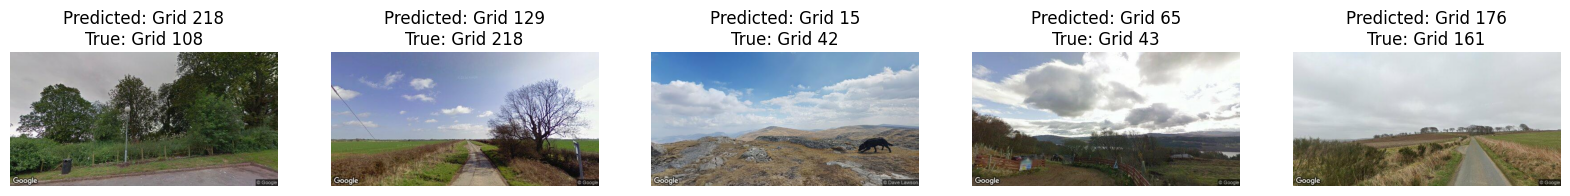

In [ ]:
import torch.nn.functional as F
import numpy as np
from geopy.distance import geodesic
import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import DistilBertTokenizer
import pickle
from shapely.geometry import Polygon

# Get center of each grid in coordinates:

Ukpolygrid = pickle.load(open("/content/drive/My Drive/ukPolyGrid.pkl",'rb'))
grid_center_coords = []
for grid,coor in Ukpolygrid.items():
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    centerx = (minx + maxx) / 2
    centery = (miny + maxy) / 2
    grid_center_coords.append((centery, centerx))

def generate_predictions(model, test_loader, maxBatches):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_image_paths = []
    all_image_coords = []

    with torch.no_grad():
        i = 0
        for batch in test_loader:
            if i > maxBatches:
                break
            images = batch['image'].to(device)
            true_labels = batch['grid']
            image_paths = batch['path']  # Assuming 'image_path' contains the paths
            coords = batch['coords']

            # Forward pass
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)

            # Normalize the embeddings
            image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

            # Store the results
            all_predictions.extend(image_embeddings.cpu().numpy())
            all_true_labels.extend(true_labels)
            all_image_paths.extend(image_paths)
            all_image_coords.extend(coords)
            i+= 1

    return np.array(all_predictions), all_true_labels, all_image_paths, all_image_coords

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel().to(device)
model.load_state_dict(torch.load("drive/MyDrive/best_uk_grid.pt", map_location=device))

predictions, true_labels, image_paths, image_coords = generate_predictions(model, test_loader, 50)

def calculate_accuracy(model, predictions, true_labels, grids, image_coords):
    grid_embeddings = []

    # Generate embeddings for all grid labels
    for grid in grids:
        label = grid
        tokenized_label = tokenizer(label, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
        with torch.no_grad():
            text_features = model.text_encoder(
                input_ids=tokenized_label["input_ids"].to(device),
                attention_mask=tokenized_label["attention_mask"].to(device)
            )
            text_embedding = model.text_projection(text_features)
            text_embedding = F.normalize(text_embedding, p=2, dim=-1)
            grid_embeddings.append(text_embedding.cpu().numpy())

    grid_embeddings = np.vstack(grid_embeddings)
    grid_indices = {grid: idx for idx, grid in enumerate(grid)}

    correct_predictions = 0
    total_predictions = len(predictions)
    total_distance = 0
    distances = []
    topdf = pd.read_csv("/content/drive/My Drive/uk_cities_top_150.csv") # changed from top 50
    predicted_labels = []

    for i, img_embedding in enumerate(predictions):
        similarities = np.dot(grid_embeddings, img_embedding)
        predicted_index = np.argmax(similarities)

        predicted_grid = grids[predicted_index]
        true_grid = true_labels[i]

        predicted_coords = image_coords[predicted_index]
        true_grid_number = int(true_grid[4:])
        true_coords = grid_center_coords[true_grid_number] # Given grid index i, we get the center of that grid

        predicted_labels.append(predicted_grid)

        if predicted_grid == true_grid:
            correct_predictions += 1

        dist = distance(predicted_coords, true_coords)
        total_distance += dist
        distances.append(dist)

    accuracy = correct_predictions / total_predictions
    average_distance = total_distance / total_predictions
    thresholds = [25, 75, 150]
    out_percentages = []
    for threshold in thresholds:
        total_in_threshold = 0
        for dist in distances:
            if dist < threshold:
                total_in_threshold+=1
        out_percentages.append((threshold, total_in_threshold/len(distances)))

    return accuracy, average_distance, predicted_labels, out_percentages

def distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

grids = dataset.grids
accuracy, average_distance, predicted_labels, percentages = calculate_accuracy(model, predictions, true_labels, grids, image_coords)
print(f"Test Dataset (10%) Accuracy: {accuracy * 100:.2f}%")
print(f"Average Distance: {average_distance} KM")
print(f'Number of Predictions: {len(predictions)}')
#print(f'Number of Unique Cities After Using Parent City: {len(cities)}')
for (threshold, percentage) in percentages:
    print(f"Percentage of predictions within {threshold} KM: {percentage * 100:.2f}%")

# Select 5 random images
indices = random.sample(range(len(image_paths)), 5)

# Plot the images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for idx, ax in zip(indices, axes):
    image_path = image_paths[idx]
    image = plt.imread(image_path)
    predicted_label = predicted_labels[idx]
    true_label = true_labels[idx]

    ax.imshow(image)
    ax.set_title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    ax.axis('off')

plt.show()


# Code to clear GPU RAM




In [ ]:
import gc

model = None
gc.collect()
torch.cuda.empty_cache()

# Sources:

https://arxiv.org/pdf/2302.00275

https://github.com/moein-shariatnia/OpenAI-CLIP